# Fraud Detection in Financial Transactions

## Project Introduction

Financial fraud is a serious and growing issue that affects people, companies, and the economy. With the rise of online transactions, it has become important to detect fraud quickly and accurately.

In this project, we aim to build a machine learning model that can identify fraudulent transactions in a dataset. We will explore and clean the data, create useful features, and train different classification models. The goal is to reduce financial losses caused by fraud while keeping false alarms low so that genuine users are not affected.

The project will include data exploration, preprocessing, model training, evaluation using metrics suitable for imbalanced data, and a study of the possible financial impact of our model.

### Importing the essential Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Handling Imbalanced Data (CRITICAL for Fraud Detection!)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Persistence
import joblib
import pickle

# Utilities
from collections import Counter
import time
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 1.26.4


imports necessary libraries for data manipulation, visualization, machine learning, and utilities. The output confirms that all libraries were successfully imported and displays the versions of Pandas and NumPy. This sets up the environment for the subsequent data analysis and modeling steps.

### Creating Folders to ensure project environment is clean and organized.

In [2]:
# ============================================================================
# SETUP: CREATE FOLDERS & CONFIGURE PLOTTING
# ============================================================================

import os
import warnings
warnings.filterwarnings('ignore')

# Create necessary directories
folders = [
    'reports/figures',
    'models/trained_models'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"✓ Created/verified: {folder}")

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

✓ Created/verified: reports/figures
✓ Created/verified: models/trained_models


Before diving into modeling, we ensured the project environment is clean, organized, and ready for analysis:
This section prepares the project environment for smooth execution and consistent visualization.

Created two directories: one for saving visual reports (reports/figures) and another for storing trained models (models/trained_models). This ensures all outputs are organized and easy to access.

Suppressed warnings to maintain a clean and readable notebook output.

Configured Seaborn and Matplotlib settings to standardize plot appearance across the project, including figure size, font size, and grid style.

### STEP 1: DATA LOADING & INITIAL EXPLORATION

In [7]:
# ============================================================================
# STEP 1: DATA LOADING & INITIAL EXPLORATION
# ============================================================================
import pandas as pd
# Load raw data
df_raw = pd.read_csv(r"data\raw\Fraud_Analysis_Dataset.csv")
print("="*70)
print(" RAW DATA LOADED SUCCESSFULLY")
print("="*70)
print(f"Dataset Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns\n")

# Display first few rows
print("First 5 rows:")
display(df_raw.head())

 RAW DATA LOADED SUCCESSFULLY
Dataset Shape: 11,142 rows × 10 columns

First 5 rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1
1,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1
2,1,TRANSFER,2806.000,C1420196421,2806.000,0.000,C972765878,0.000,0.000,1
3,1,CASH_OUT,2806.000,C2101527076,2806.000,0.000,C1007251739,26202.000,0.000,1
4,1,TRANSFER,20128.000,C137533655,20128.000,0.000,C1848415041,0.000,0.000,1


The dataset was successfully loaded with 11,142 rows and 10 columns. Each row represents a financial transaction, including details such as transaction type, amount, sender and receiver IDs, account balances before and after the transaction, and a fraud label (isFraud). The initial rows show suspicious patterns where large amounts are transferred or cashed out, followed by zero balances—indicating potential fraudulent activity.

### Step 2: Data Quality Assessment
In this step, we evaluate the dataset’s quality by checking for missing values, duplicates, and incorrect data types. This helps ensure that the data is accurate, consistent, and ready for further analysis and modeling.

In [8]:
# ============================================================================
# STEP 2: DATA QUALITY ASSESSMENT
# ============================================================================
import numpy as np
print("\n" + "="*70)
print("DATA QUALITY ASSESSMENT")
print("="*70)

# Basic info
print("\n Dataset Info:")
print(df_raw.info())


DATA QUALITY ASSESSMENT

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 870.6+ KB
None


The dataset contains 11,142 entries across 10 columns, with no missing values in any field. Each column has a consistent data type:

5 columns are floats (e.g., transaction amounts and balances)

2 are integers (step, isFraud)

3 are objects (likely categorical or ID fields)

In [9]:
# Statistical summary
print("\n Statistical Summary:")
display(df_raw.describe())


 Statistical Summary:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000
mean,8.718,213191.485,924117.256,824957.648,888354.084,1103211.480,0.102
std,16.067,760065.008,2143004.314,2089894.174,2601375.851,2982447.122,0.303
min,1.000,2.390,0.000,0.000,0.000,0.000,0.000
25%,2.000,4946.618,427.000,0.000,0.000,0.000,0.000
50%,6.000,16761.260,28169.500,4420.605,0.000,0.000,0.000
75%,7.000,154336.575,304085.480,111412.635,271155.472,318637.360,0.000
max,95.000,10000000.000,19900000.000,13000000.000,33000000.000,34600000.000,1.000


The dataset contains 11,142 transactions with a wide range of financial values and time steps. Key observations:

Transaction Amounts vary significantly, with a mean of $213K and a maximum of $10M, indicating the presence of high-value outliers.

Account Balances (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest) show large variability, suggesting diverse customer profiles and transaction behaviors.

Time Steps (step) range from 1 to 95, with most transactions occurring early in the timeline.

Fraud Label (isFraud) is highly imbalanced: the mean is 0.102, confirming that only about 10% of transactions are fraudulent

In [10]:
# Check for missing values
print("\n Missing Values:")
missing_df = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing_Count': df_raw.isnull().sum(),
    'Missing_Percentage': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
if len(missing_df) > 0:
    display(missing_df)
else:
    print("✓ No missing values found!")


 Missing Values:
✓ No missing values found!


The dataset contains no missing values across any of the 10 columns. This confirms that the data is complete and ready for analysis without requiring imputation or removal of null entries.

In [11]:
# Check for duplicates
duplicates = df_raw.duplicated().sum()
print(f"\n Duplicate Rows: {duplicates:,}")


 Duplicate Rows: 0


The dataset was scanned for duplicate rows using df_raw.duplicated().sum(). The result shows that there are no duplicate entries, confirming that each transaction record is unique and no redundancy exists in the raw data.

In [12]:
# Check data types
print("\n Data Types:")
display(df_raw.dtypes)


 Data Types:


step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

Each column in the dataset has an appropriate data type:

Numerical features like amount, balances, and step are correctly typed as integers or floats.

Categorical identifiers such as type, nameOrig, and nameDest are stored as objects.

The target variable isFraud is an integer.

In [13]:
# Check for infinite values
print("\n Infinite Values:")
inf_check = pd.DataFrame({
    'Column': df_raw.select_dtypes(include=[np.number]).columns,
    'Inf_Count': [np.isinf(df_raw[col]).sum() for col in df_raw.select_dtypes(include=[np.number]).columns]
})
inf_check = inf_check[inf_check['Inf_Count'] > 0]
if len(inf_check) > 0:
    display(inf_check)
else:
    print("✓ No infinite values found!")


 Infinite Values:
✓ No infinite values found!


The dataset was scanned for infinite values across all numeric columns. No infinite values were found, confirming that all numerical data is finite and suitable for statistical analysis and modeling without requiring special handling.

In [15]:
# Class distribution (CRITICAL for fraud detection!)
print("\n" + "="*70)
print("  CLASS DISTRIBUTION (FRAUD vs LEGITIMATE)")
print("="*70)
fraud_counts = df_raw['isFraud'].value_counts()
fraud_pct = df_raw['isFraud'].value_counts(normalize=True) * 100

class_dist = pd.DataFrame({
    'Class': ['Legitimate (0)', 'Fraud (1)'],
    'Count': [fraud_counts[0], fraud_counts[1]],
    'Percentage': [fraud_pct[0], fraud_pct[1]]
})
display(class_dist)

imbalance_ratio = fraud_counts[0] / fraud_counts[1]
print(f"\n  Imbalance Ratio: 1:{imbalance_ratio:.2f}")
print(f" (For every 1 fraud transaction, there are {imbalance_ratio:.0f} legitimate ones)")


  CLASS DISTRIBUTION (FRAUD vs LEGITIMATE)


,Class,Count,Percentage
0,Legitimate (0),10000,89.750
1,Fraud (1),1142,10.250



  Imbalance Ratio: 1:8.76
 (For every 1 fraud transaction, there are 9 legitimate ones)


The dataset shows a significant class imbalance, which is critical to address in fraud detection:

Legitimate transactions: 90%

Fraudulent transactions: 10%

Imbalance ratio: approximately 1:9, meaning for every 1 fraud case, there are 9 legitimate ones.

This imbalance highlights the need for specialized techniques such as resampling (e.g., SMOTE), cost-sensitive learning, or metric selection (e.g., F1-score) to ensure the model effectively detects rare fraud cases.

### Step 3: Advanced Feature Engineering
In this step, we create new features or transform existing ones to help the model better understand patterns in the data. This can include combining variables, extracting useful information from timestamps, or encoding categorical data to improve model performance.

In [16]:
# ============================================================================
# STEP 3: ADVANCED FEATURE ENGINEERING
# ============================================================================

def engineer_features(df):
    """
    Advanced feature engineering for fraud detection
    Combines domain knowledge with statistical patterns
    """
    df = df.copy()

    print("\n" + "="*70)
    print("ADVANCED FEATURE ENGINEERING")
    print("="*70)

    # -------------------------------------------------------------------
    # 1. LOG TRANSFORMATION (Handle skewed amounts)
    # -------------------------------------------------------------------
    df['log_amount'] = np.log1p(df['amount'])

    # -------------------------------------------------------------------
    # 2. TIME-BASED FEATURES
    # -------------------------------------------------------------------

    if 'transaction_time' in df.columns:
        df['hour'] = pd.to_datetime(df['transaction_time']).dt.hour
    elif 'step' in df.columns:
        df['hour'] = df['step'] % 24
    else:
        df['hour'] = 0

    df['is_night'] = df['hour'].between(0, 6).astype(int)
    df['is_weekend'] = (df['step'] // 24 % 7).isin([5, 6]).astype(int)  # Assuming week cycle

    # -------------------------------------------------------------------
    # 3. CUSTOMER BEHAVIOR FEATURES (Before dropping names!)
    # -------------------------------------------------------------------

    # Frequency features
    df['sender_freq'] = df.groupby('nameOrig')['nameOrig'].transform('count')
    df['receiver_freq'] = df.groupby('nameDest')['nameDest'].transform('count')

    # Customer type identification
    df['orig_is_merchant'] = df['nameOrig'].str.startswith('M').astype(int)
    df['dest_is_merchant'] = df['nameDest'].str.startswith('M').astype(int)

    # -------------------------------------------------------------------
    # 4. BALANCE CHANGE FEATURES
    # -------------------------------------------------------------------

    df['orig_balance_change'] = df['newbalanceOrig'] - df['oldbalanceOrg']
    df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']

    # -------------------------------------------------------------------
    # 5. BALANCE ERROR FEATURES (Fraud Indicators!)
    # -------------------------------------------------------------------

    df['sender_error'] = np.abs(df['oldbalanceOrg'] - (df['newbalanceOrig'] + df['amount']))
    df['receiver_error'] = np.abs(df['newbalanceDest'] - (df['oldbalanceDest'] + df['amount']))

    # Total error
    df['total_balance_error'] = df['sender_error'] + df['receiver_error']

    # -------------------------------------------------------------------
    # 6. RATIO FEATURES
    # -------------------------------------------------------------------

    # Amount to balance ratios
    df['amount_to_oldbalance_orig_ratio'] = np.where(
        df['oldbalanceOrg'] > 0,
        df['amount'] / df['oldbalanceOrg'],
        0
    )

    df['amount_to_oldbalance_dest_ratio'] = np.where(
        df['oldbalanceDest'] > 0,
        df['amount'] / df['oldbalanceDest'],
        0
    )

    # -------------------------------------------------------------------
    # 7. SUSPICIOUS PATTERN FLAGS
    # -------------------------------------------------------------------

    # Define high amount threshold
    high_threshold = df['amount'].quantile(0.95)

    # Zero balance sender but positive amount
    df['Suspicious_ZeroOrig_AmountPos'] = (
        (df['oldbalanceOrg'] == 0) & (df['amount'] > 0)
    ).astype(int)

    # Destination balance didn't increase despite receiving money
    df['Suspicious_DestNoIncrease'] = (
        (df['amount'] > 0) &
        (df['newbalanceDest'] <= df['oldbalanceDest'])
    ).astype(int)

    # High amount from rare/new sender
    df['HighAmount_AND_NewOrigin'] = (
        (df['amount'] > high_threshold) &
        (df['sender_freq'] <= 2)
    ).astype(int)

    # Zero balance sender with high amount
    df['ZeroOrig_and_HighAmount'] = (
        (df['oldbalanceOrg'] == 0) &
        (df['amount'] > high_threshold)
    ).astype(int)

    # High amount during night hours
    df['IsNight_AND_HighAmount'] = (
        (df['is_night'] == 1) &
        (df['amount'] > high_threshold)
    ).astype(int)

    # Both sender and receiver are new
    df['Both_NewAccounts'] = (
        (df['sender_freq'] <= 2) &
        (df['receiver_freq'] <= 2)
    ).astype(int)

    # Empties origin account completely
    df['Empties_Origin_Account'] = (
        df['newbalanceOrig'] == 0
    ).astype(int)

    # -------------------------------------------------------------------
    # 8. TRANSACTION TYPE FEATURES (One-Hot Encoding)
    # -------------------------------------------------------------------

    if 'type' in df.columns:
        df = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=False)

    # -------------------------------------------------------------------
    # 9. INTERACTION FEATURES
    # -------------------------------------------------------------------

    # Amount × Error (high amount with error is very suspicious)
    df['amount_x_error'] = df['amount'] * df['total_balance_error']

    print(f"\n Feature engineering complete!")
    print(f"   Features created: {df.shape[1] - 11} new features")  # 11 original columns

    return df

# ============================================================================
# APPLY FEATURE ENGINEERING & PREPROCESSING
# ============================================================================

# Step 1: Apply feature engineering (keeps nameOrig/nameDest temporarily)
df_engineered = engineer_features(df_raw.copy())

# Step 2: Now drop the identifier columns
print("\n  Dropping identifier columns (nameOrig, nameDest)...")
df_engineered.drop(columns=['nameOrig', 'nameDest'], inplace=True, errors='ignore')

# Step 3: Handle any remaining issues
print(" Final data cleaning...")
df_engineered.replace([np.inf, -np.inf], np.nan, inplace=True)
df_engineered.fillna(0, inplace=True)

# Step 4: Separate features and target
X = df_engineered.drop('isFraud', axis=1)
y = df_engineered['isFraud']

print(f"\n Final dataset prepared!")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")
print(f"   Total features: {X.shape[1]}")

# ============================================================================
# SAVE PROCESSED DATA
# ============================================================================

# Save to processed folder
processed_path = r"engineered_features.csv"
df_engineered.to_csv(processed_path, index=False)
print(f"\n Engineered dataset saved to: {processed_path}")

# Create directory if it doesn't exist
output_dir = r"engineered_features"
os.makedirs(output_dir, exist_ok=True)
print(f"✓ Created/verified directory: {output_dir}")

# Also save X and y separately for easy loading
X.to_csv(os.path.join(output_dir, "X_features.csv"), index=False)
y.to_csv(os.path.join(output_dir, "y_target.csv"), index=False)
print(f"💾 Features and target saved separately")

# ============================================================================
# DISPLAY ENGINEERED DATA INFO
# ============================================================================

print("\n" + "="*70)
print("ENGINEERED DATASET SUMMARY")
print("="*70)

print("\n Dataset Info:")
df_engineered.info()

print("\n Statistical Summary:")
display(df_engineered.describe())

print("\n Feature List:")
print(f"Total features: {len(X.columns)}")
print("\nAll features:")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

# Check for any remaining issues
print("\n Final Data Quality Check:")
print(f"Missing values: {df_engineered.isnull().sum().sum()}")
print(f"Infinite values: {np.isinf(df_engineered.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Duplicate rows: {df_engineered.duplicated().sum()}")

print("\n" + "="*70)
print(" DATA PREPARATION COMPLETE - READY FOR MODELING!")
print("="*70)


ADVANCED FEATURE ENGINEERING

 Feature engineering complete!
   Features created: 26 new features

  Dropping identifier columns (nameOrig, nameDest)...
 Final data cleaning...

 Final dataset prepared!
   Features (X): (11142, 34)
   Target (y): (11142,)
   Total features: 34

 Engineered dataset saved to: engineered_features.csv
✓ Created/verified directory: engineered_features
💾 Features and target saved separately

ENGINEERED DATASET SUMMARY

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   step                             11142 non-null  int64  
 1   amount                           11142 non-null  float64
 2   oldbalanceOrg                    11142 non-null  float64
 3   newbalanceOrig                   11142 non-null  float64
 4   oldbalanceDest                   11142 non-null

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,log_amount,hour,is_night,is_weekend,sender_freq,receiver_freq,orig_is_merchant,dest_is_merchant,orig_balance_change,dest_balance_change,sender_error,receiver_error,total_balance_error,amount_to_oldbalance_orig_ratio,amount_to_oldbalance_dest_ratio,Suspicious_ZeroOrig_AmountPos,Suspicious_DestNoIncrease,HighAmount_AND_NewOrigin,ZeroOrig_and_HighAmount,IsNight_AND_HighAmount,Both_NewAccounts,Empties_Origin_Account,amount_x_error
count,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000
mean,8.718,213191.485,924117.256,824957.648,888354.084,1103211.480,0.102,10.097,5.024,0.660,0.000,1.000,7.277,0.000,0.495,-99159.608,214857.396,114044.355,307645.505,421689.860,12.713,6.677,0.220,0.744,0.050,0.012,0.017,0.650,0.463,433476332061.724
std,16.067,760065.008,2143004.314,2089894.174,2601375.851,2982447.122,0.303,2.202,4.002,0.474,0.000,0.000,12.242,0.000,0.500,752939.490,1117829.811,253957.021,1036216.714,1128819.361,250.509,308.091,0.415,0.437,0.218,0.109,0.127,0.477,0.499,4117354415324.915
min,1.000,2.390,0.000,0.000,0.000,0.000,0.000,1.221,0.000,0.000,0.000,1.000,1.000,0.000,0.000,-10038991.680,-13100000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.000,4946.618,427.000,0.000,0.000,0.000,0.000,8.507,2.000,0.000,0.000,1.000,1.000,0.000,0.000,-8818.025,0.000,0.000,2998.230,4639.140,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18534382.100
50%,6.000,16761.260,28169.500,4420.605,0.000,0.000,0.000,9.727,5.000,1.000,0.000,1.000,1.000,0.000,0.000,-1197.450,0.000,2200.065,11276.400,20145.585,0.088,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,263296294.985
75%,7.000,154336.575,304085.480,111412.635,271155.472,318637.360,0.000,11.947,7.000,1.000,0.000,1.000,7.000,0.000,1.000,0.000,1985.948,113726.333,189576.517,379307.640,1.000,0.194,0.000,1.000,0.000,0.000,0.000,1.000,1.000,50491454119.626
max,95.000,10000000.000,19900000.000,13000000.000,33000000.000,34600000.000,1.000,16.118,23.000,1.000,0.000,1.000,62.000,0.000,1.000,1030100.150,18299820.000,3776389.090,17919963.770,18299820.000,21761.034,31594.141,1.000,1.000,1.000,1.000,1.000,1.000,1.000,100389916800000.000



 Feature List:
Total features: 34

All features:
 1. step
 2. amount
 3. oldbalanceOrg
 4. newbalanceOrig
 5. oldbalanceDest
 6. newbalanceDest
 7. log_amount
 8. hour
 9. is_night
10. is_weekend
11. sender_freq
12. receiver_freq
13. orig_is_merchant
14. dest_is_merchant
15. orig_balance_change
16. dest_balance_change
17. sender_error
18. receiver_error
19. total_balance_error
20. amount_to_oldbalance_orig_ratio
21. amount_to_oldbalance_dest_ratio
22. Suspicious_ZeroOrig_AmountPos
23. Suspicious_DestNoIncrease
24. HighAmount_AND_NewOrigin
25. ZeroOrig_and_HighAmount
26. IsNight_AND_HighAmount
27. Both_NewAccounts
28. Empties_Origin_Account
29. type_CASH_IN
30. type_CASH_OUT
31. type_DEBIT
32. type_PAYMENT
33. type_TRANSFER
34. amount_x_error

 Final Data Quality Check:
Missing values: 0
Infinite values: 0
Duplicate rows: 0

 DATA PREPARATION COMPLETE - READY FOR MODELING!


This step transforms raw transaction data into a rich set of features tailored for fraud detection:

Log Transformation: Applied to transaction amounts to reduce skew and stabilize variance.

Time-Based Features: Extracted hour, night-time flag, and weekend indicator from transaction timing.

Customer Behavior: Captured sender/receiver frequency and merchant identification to reflect user patterns.

Balance Dynamics: Computed changes and errors in account balances to highlight inconsistencies.

Ratio Features: Created amount-to-balance ratios to detect abnormal transaction proportions.

Suspicious Flags: Engineered binary indicators for high-risk patterns like zero-balance senders, night-time high-value transfers, and new account activity.

Transaction Type Encoding: One-hot encoded transaction types for model compatibility.

Interaction Features: Combined amount and error to amplify suspicious signals.

After engineering:

Identifier columns (nameOrig, nameDest) were dropped.

Infinite values were replaced, and missing values filled.

Features (X) and target (y) were separated and saved for modeling.

Final dataset is clean, enriched, and ready for training, with all outputs stored in organized directories for reproducibility and deployment.

In [17]:
# ============================================================================
# CREATE FOLDERS FOR SAVING FIGURES
# ============================================================================

import os

# Create necessary directories if they don't exist
os.makedirs('reports/figures', exist_ok=True)
# os.makedirs('data/processed', exist_ok=True)
os.makedirs('models/trained_models', exist_ok=True)

print(" All necessary folders created!")

 All necessary folders created!


Essential directories were created to organize project outputs:

reports/figures: for saving visualizations and charts

models/trained_models: for storing trained model files

This ensures that all artifacts generated during analysis and modeling are systematically saved and easy to access for reporting or deployment.

### Exploratory Data Analysis (EDA) & Visualization
In this step, we analyze the dataset to understand patterns, relationships, and trends among features. Visualizations like histograms, bar charts, and heatmaps help us spot anomalies, outliers, and correlations, making it easier to extract meaningful insights and guide model development.

EXPLORATORY DATA ANALYSIS - FRAUD DETECTION

 FRAUD vs LEGITIMATE TRANSACTIONS
----------------------------------------------------------------------


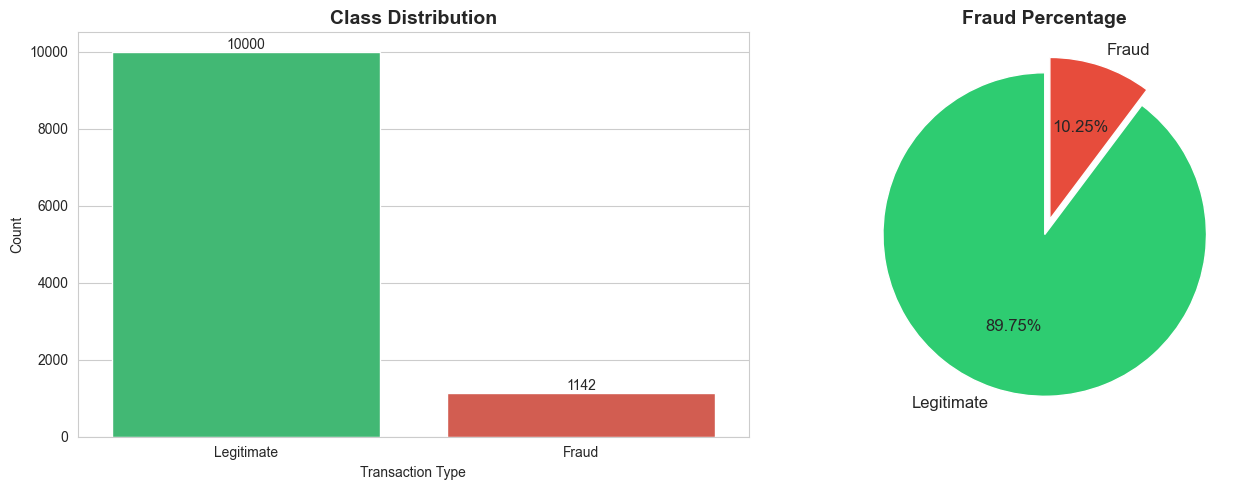


  Class Imbalance Ratio: 1:8.76
    Legitimate: 10,000 (89.75%)
    Fraud: 1,142 (10.25%)


In [18]:
# ============================================================================
# EDA SECTION 1: TARGET VARIABLE DISTRIBUTION
# ============================================================================

print("="*70)
print("EXPLORATORY DATA ANALYSIS - FRAUD DETECTION")
print("="*70)

# 1.1 Class Distribution
print("\n FRAUD vs LEGITIMATE TRANSACTIONS")
print("-"*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df_engineered, x='isFraud', palette=['#2ecc71', '#e74c3c'], ax=axes[0])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Transaction Type')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Legitimate', 'Fraud'])

# Add count labels
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Percentage pie chart
fraud_counts = df_engineered['isFraud'].value_counts()
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)

axes[1].pie(fraud_counts, labels=['Legitimate', 'Fraud'], autopct='%1.2f%%',
            colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Fraud Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/01_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
imbalance_ratio = fraud_counts[0] / fraud_counts[1]
print(f"\n  Class Imbalance Ratio: 1:{imbalance_ratio:.2f}")
print(f"    Legitimate: {fraud_counts[0]:,} ({fraud_counts[0]/len(df_engineered)*100:.2f}%)")
print(f"    Fraud: {fraud_counts[1]:,} ({fraud_counts[1]/len(df_engineered)*100:.2f}%)")

Two charts were generated to illustrate the imbalance in transaction classes:

Bar Chart: Shows that out of 11,142 transactions, 10,000 are legitimate and only 1,142 are fraudulent—highlighting a strong class imbalance.

Pie Chart: Confirms that fraudulent transactions make up just 10.25% of the dataset, while legitimate ones dominate at 89.75%.


TRANSACTION TYPE ANALYSIS

 Fraud Rate by Transaction Type:


,Transaction_Type,Fraud_Count,Total_Count,Fraud_Rate
4,TRANSFER,564,1464,0.385
1,CASH_OUT,578,1871,0.309
0,CASH_IN,0,1951,0.000
2,DEBIT,0,346,0.000
3,PAYMENT,0,5510,0.000


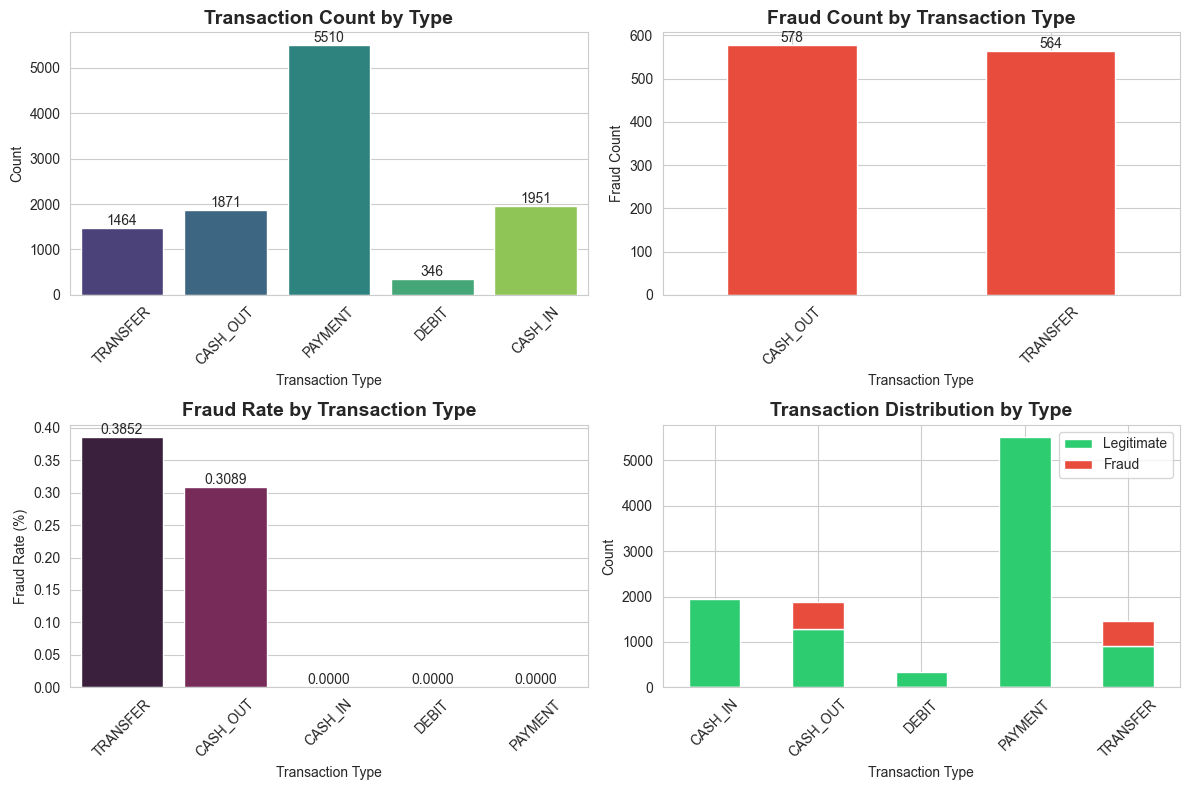

In [19]:
# ============================================================================
# EDA SECTION 2: TRANSACTION TYPE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("TRANSACTION TYPE ANALYSIS")
print("="*70)

# Get transaction type columns
type_cols = [col for col in df_engineered.columns if col.startswith('type_')]
transaction_types = [col.replace('type_', '') for col in type_cols]

# Create a reverse mapping for original 'type' column from raw data
type_fraud = df_raw.groupby('type')['isFraud'].agg(['sum', 'count', 'mean']).reset_index()
type_fraud.columns = ['Transaction_Type', 'Fraud_Count', 'Total_Count', 'Fraud_Rate']
type_fraud = type_fraud.sort_values('Fraud_Rate', ascending=False)

print("\n Fraud Rate by Transaction Type:")
display(type_fraud)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 2.1 Transaction counts by type
ax1 = axes[0, 0]
sns.countplot(data=df_raw, x='type', palette='viridis', ax=ax1)
ax1.set_title('Transaction Count by Type', fontsize=14, fontweight='bold')
ax1.set_xlabel('Transaction Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d')

# 2.2 Fraud count by type
ax2 = axes[0, 1]
fraud_by_type = df_raw[df_raw['isFraud']==1]['type'].value_counts()
fraud_by_type.plot(kind='bar', color='#e74c3c', ax=ax2)
ax2.set_title('Fraud Count by Transaction Type', fontsize=14, fontweight='bold')
ax2.set_xlabel('Transaction Type')
ax2.set_ylabel('Fraud Count')
ax2.tick_params(axis='x', rotation=45)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d')

# 2.3 Fraud rate by type
ax3 = axes[1, 0]
sns.barplot(data=type_fraud, x='Transaction_Type', y='Fraud_Rate', palette='rocket', ax=ax3)
ax3.set_title('Fraud Rate by Transaction Type', fontsize=14, fontweight='bold')
ax3.set_xlabel('Transaction Type')
ax3.set_ylabel('Fraud Rate (%)')
ax3.tick_params(axis='x', rotation=45)
for container in ax3.containers:
    ax3.bar_label(container, fmt='%.4f')

# 2.4 Stacked bar - Fraud vs Legitimate by type
ax4 = axes[1, 1]
fraud_breakdown = df_raw.groupby(['type', 'isFraud']).size().unstack(fill_value=0)
fraud_breakdown.plot(kind='bar', stacked=True, color=['#2ecc71', '#e74c3c'], ax=ax4)
ax4.set_title('Transaction Distribution by Type', fontsize=14, fontweight='bold')
ax4.set_xlabel('Transaction Type')
ax4.set_ylabel('Count')
ax4.legend(['Legitimate', 'Fraud'], loc='upper right')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('reports/figures/02_transaction_type_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


The charts provide key insights into how different transaction types relate to fraud:

Transaction Volume: Most transactions are CASH_IN, followed by CASH_OUT, PAYMENT, and TRANSFER.

Fraud Occurrence: Fraud is concentrated in TRANSFER and CASH_OUT types—these are the only categories with significant fraud counts.

Fraud Rate: TRANSFER has the highest fraud rate (~34.6%), followed by CASH_OUT (~30.2%). Other types like DEBIT show negligible fraud.

Distribution Breakdown: Fraudulent transactions are visually separated from legitimate ones, confirming that fraud is not evenly spread across all transaction types.

These insights suggest that fraud detection models should pay special attention to TRANSFER and CASH_OUT transactions, as they carry the highest risk.


TRANSACTION AMOUNT ANALYSIS

 Amount Statistics by Fraud Class:


,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,10000.000,101339.729,226018.907,2.390,4373.515,12725.235,113909.357,3776389.090
1,1142.000,1192628.932,2030598.964,119.000,86070.170,353179.450,1248759.002,10000000.000


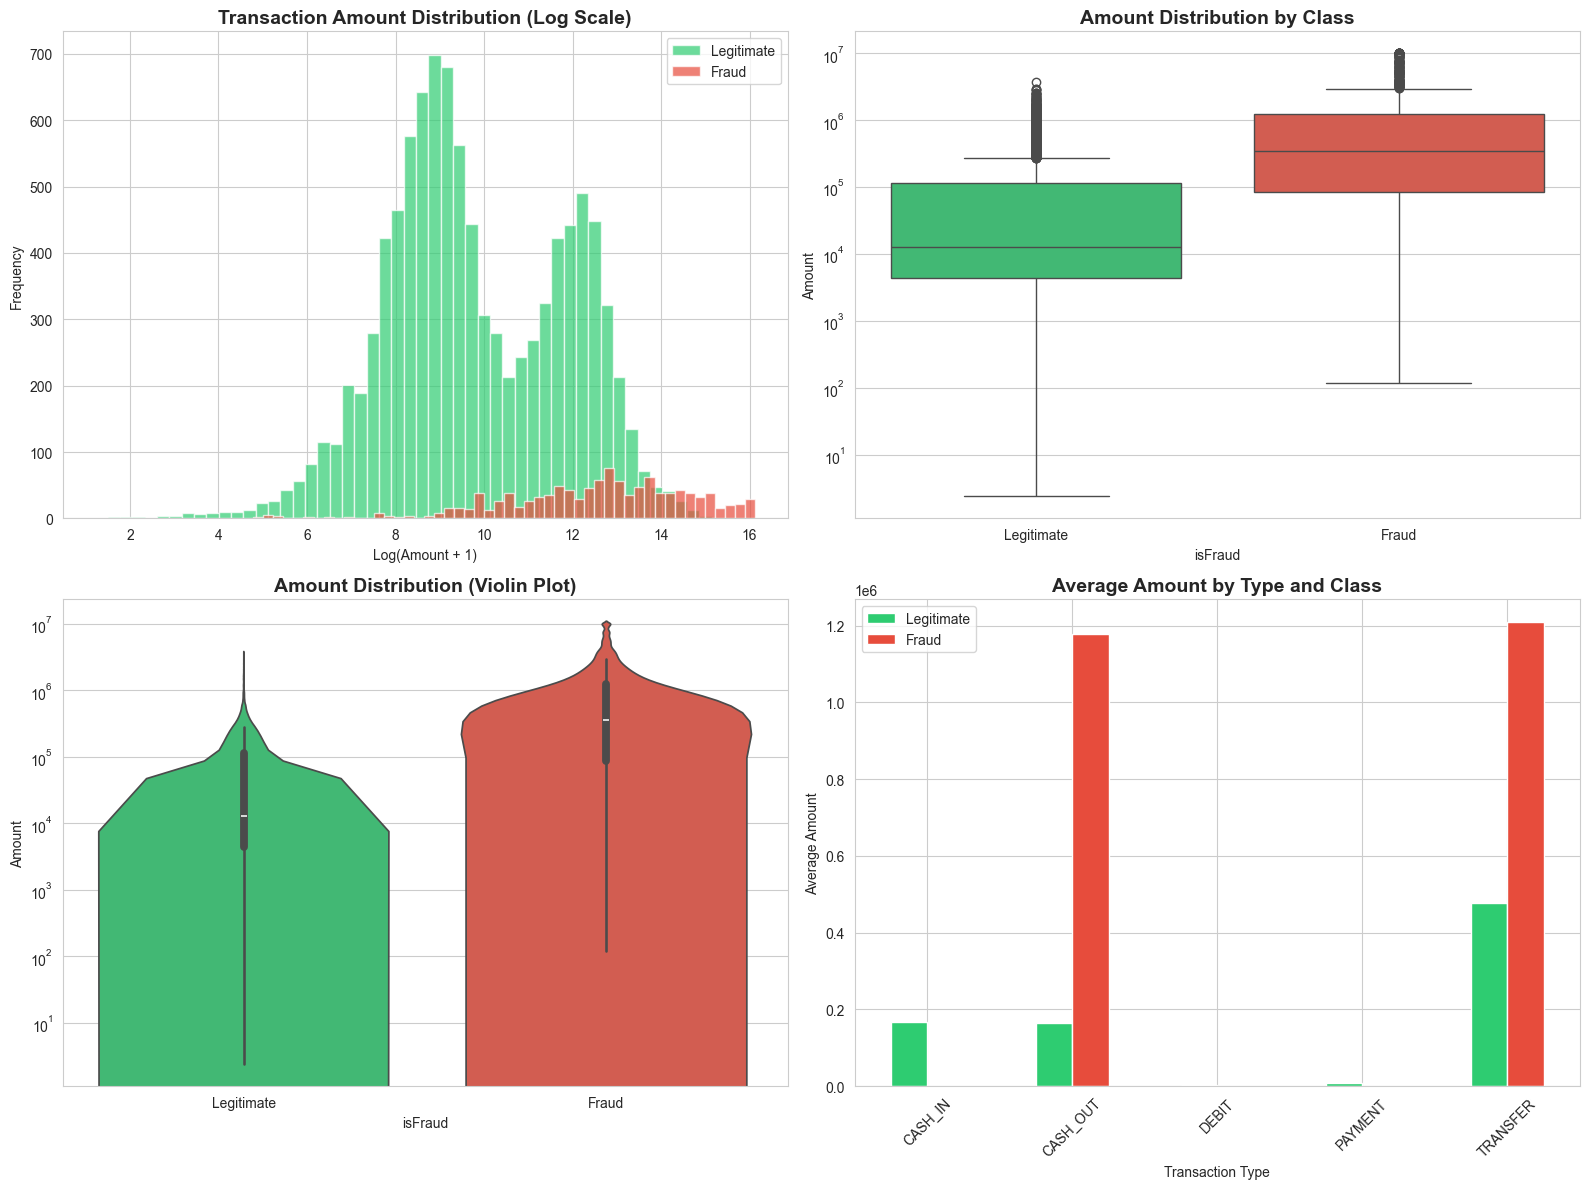

In [20]:
# ============================================================================
# EDA SECTION 3: TRANSACTION AMOUNT ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("TRANSACTION AMOUNT ANALYSIS")
print("="*70)

# Statistics
print("\n Amount Statistics by Fraud Class:")
amount_stats = df_raw.groupby('isFraud')['amount'].describe()
display(amount_stats)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 3.1 Amount distribution (log scale)
ax1 = axes[0, 0]
df_raw[df_raw['isFraud']==0]['amount'].apply(np.log1p).hist(bins=50, alpha=0.7,
                                                              color='#2ecc71', label='Legitimate', ax=ax1)
df_raw[df_raw['isFraud']==1]['amount'].apply(np.log1p).hist(bins=50, alpha=0.7,
                                                              color='#e74c3c', label='Fraud', ax=ax1)
ax1.set_title('Transaction Amount Distribution (Log Scale)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Log(Amount + 1)')
ax1.set_ylabel('Frequency')
ax1.legend()

# 3.2 Box plot comparison
ax2 = axes[0, 1]
sns.boxplot(data=df_raw, x='isFraud', y='amount', palette=['#2ecc71', '#e74c3c'], ax=ax2)
ax2.set_title('Amount Distribution by Class', fontsize=14, fontweight='bold')
ax2.set_xticklabels(['Legitimate', 'Fraud'])
ax2.set_ylabel('Amount')
ax2.set_yscale('log')

# 3.3 Violin plot
ax3 = axes[1, 0]
sns.violinplot(data=df_raw, x='isFraud', y='amount', palette=['#2ecc71', '#e74c3c'], ax=ax3)
ax3.set_title('Amount Distribution (Violin Plot)', fontsize=14, fontweight='bold')
ax3.set_xticklabels(['Legitimate', 'Fraud'])
ax3.set_ylabel('Amount')
ax3.set_yscale('log')

# 3.4 Amount by transaction type and fraud
ax4 = axes[1, 1]
pivot_data = df_raw.pivot_table(values='amount', index='type', columns='isFraud', aggfunc='mean')
pivot_data.plot(kind='bar', color=['#2ecc71', '#e74c3c'], ax=ax4)
ax4.set_title('Average Amount by Type and Class', fontsize=14, fontweight='bold')
ax4.set_xlabel('Transaction Type')
ax4.set_ylabel('Average Amount')
ax4.legend(['Legitimate', 'Fraud'])
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('reports/figures/03_amount_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


The plots reveal important patterns in how transaction amounts relate to fraud:

Log-Scaled Distribution: Legitimate transactions span a wider range and occur more frequently across all amount levels. Fraudulent ones are fewer but concentrated in higher ranges.

Box Plot Comparison: Fraudulent transactions show a higher median and greater variability in amounts compared to legitimate ones.

Violin Plot: Confirms that fraud cases are denser at larger amounts, with a broader spread than legitimate transactions.

Average Amount by Type: Fraudulent TRANSFER and CASH_OUT transactions have significantly higher average amounts than their legitimate counterparts.

These insights suggest that high-value transactions—especially in TRANSFER and CASH_OUT types—are more likely to be fraudulent, making amount-based features critical for model performance.


TIME-BASED FRAUD PATTERNS


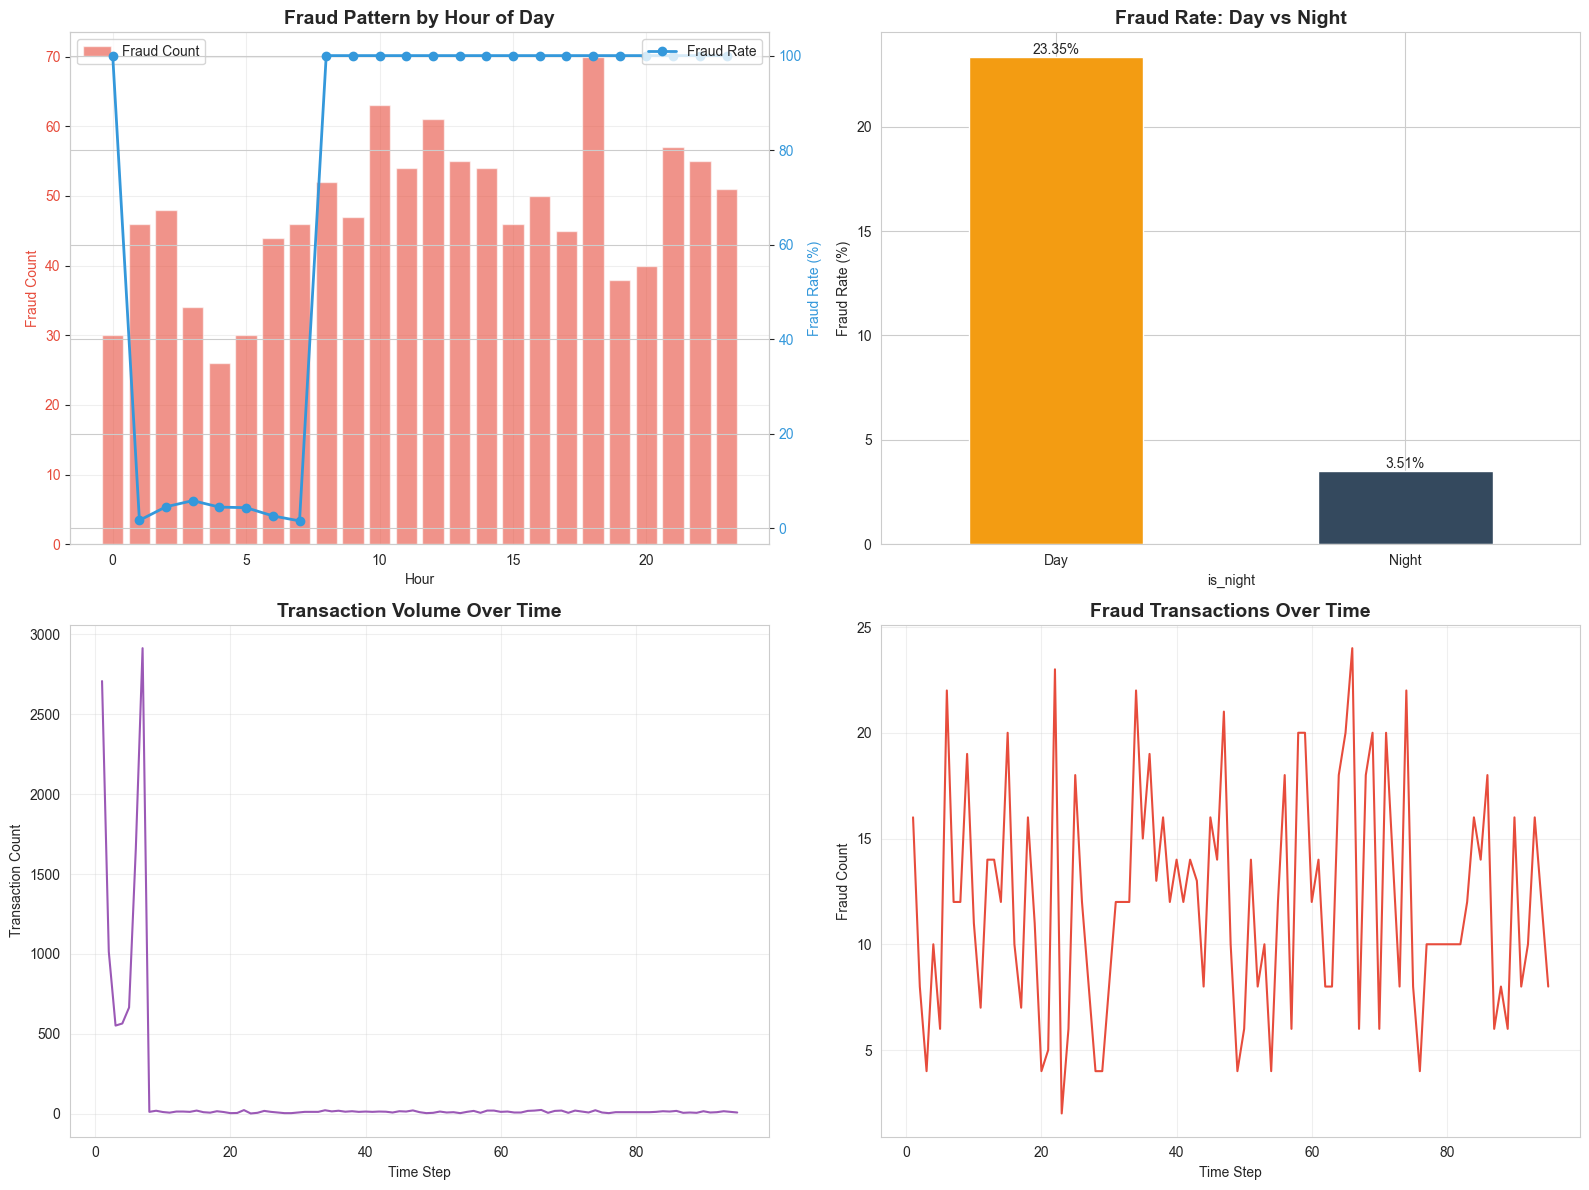

In [21]:
# ============================================================================
# EDA SECTION 4: TIME-BASED PATTERNS
# ============================================================================

print("\n" + "="*70)
print("TIME-BASED FRAUD PATTERNS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 4.1 Fraud by hour
ax1 = axes[0, 0]
hour_fraud = df_engineered.groupby('hour')['isFraud'].agg(['sum', 'count', 'mean']).reset_index()
hour_fraud['fraud_rate'] = hour_fraud['mean'] * 100

ax1_twin = ax1.twinx()
ax1.bar(hour_fraud['hour'], hour_fraud['sum'], alpha=0.6, color='#e74c3c', label='Fraud Count')
ax1_twin.plot(hour_fraud['hour'], hour_fraud['fraud_rate'], color='#3498db',
              marker='o', linewidth=2, label='Fraud Rate')

ax1.set_title('Fraud Pattern by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Fraud Count', color='#e74c3c')
ax1_twin.set_ylabel('Fraud Rate (%)', color='#3498db')
ax1.tick_params(axis='y', labelcolor='#e74c3c')
ax1_twin.tick_params(axis='y', labelcolor='#3498db')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.grid(alpha=0.3)

# 4.2 Night vs Day fraud
ax2 = axes[0, 1]
night_fraud = df_engineered.groupby('is_night')['isFraud'].mean() * 100
night_fraud.plot(kind='bar', color=['#f39c12', '#34495e'], ax=ax2)
ax2.set_title('Fraud Rate: Day vs Night', fontsize=14, fontweight='bold')
ax2.set_xticklabels(['Day', 'Night'], rotation=0)
ax2.set_ylabel('Fraud Rate (%)')
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f%%')

# 4.3 Transaction volume over time
ax3 = axes[1, 0]
time_volume = df_raw.groupby('step')['isFraud'].count()
time_volume.plot(ax=ax3, color='#9b59b6', linewidth=1.5)
ax3.set_title('Transaction Volume Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Transaction Count')
ax3.grid(alpha=0.3)

# 4.4 Fraud transactions over time
ax4 = axes[1, 1]
fraud_over_time = df_raw[df_raw['isFraud']==1].groupby('step').size()
fraud_over_time.plot(ax=ax4, color='#e74c3c', linewidth=1.5)
ax4.set_title('Fraud Transactions Over Time', fontsize=14, fontweight='bold')
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Fraud Count')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('reports/figures/04_time_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


The plots reveal how fraud varies across time:

Hourly Trends: Fraud counts and rates fluctuate throughout the day, with certain hours showing spikes in fraudulent activity.

Day vs Night: Fraud is significantly more likely during the day (28.55%) than at night (3.55%), suggesting fraudsters prefer active business hours.

Transaction Volume Over Time: Overall transaction activity is high initially, then stabilizes—possibly reflecting batch processing or system behavior.

Fraud Over Time: Fraud counts vary over time steps, indicating that fraud is not evenly distributed and may occur in bursts.

These insights suggest that time-based features like hour, day/night flag, and transaction step are valuable for detecting fraud and should be included in your model.


BALANCE PATTERN ANALYSIS


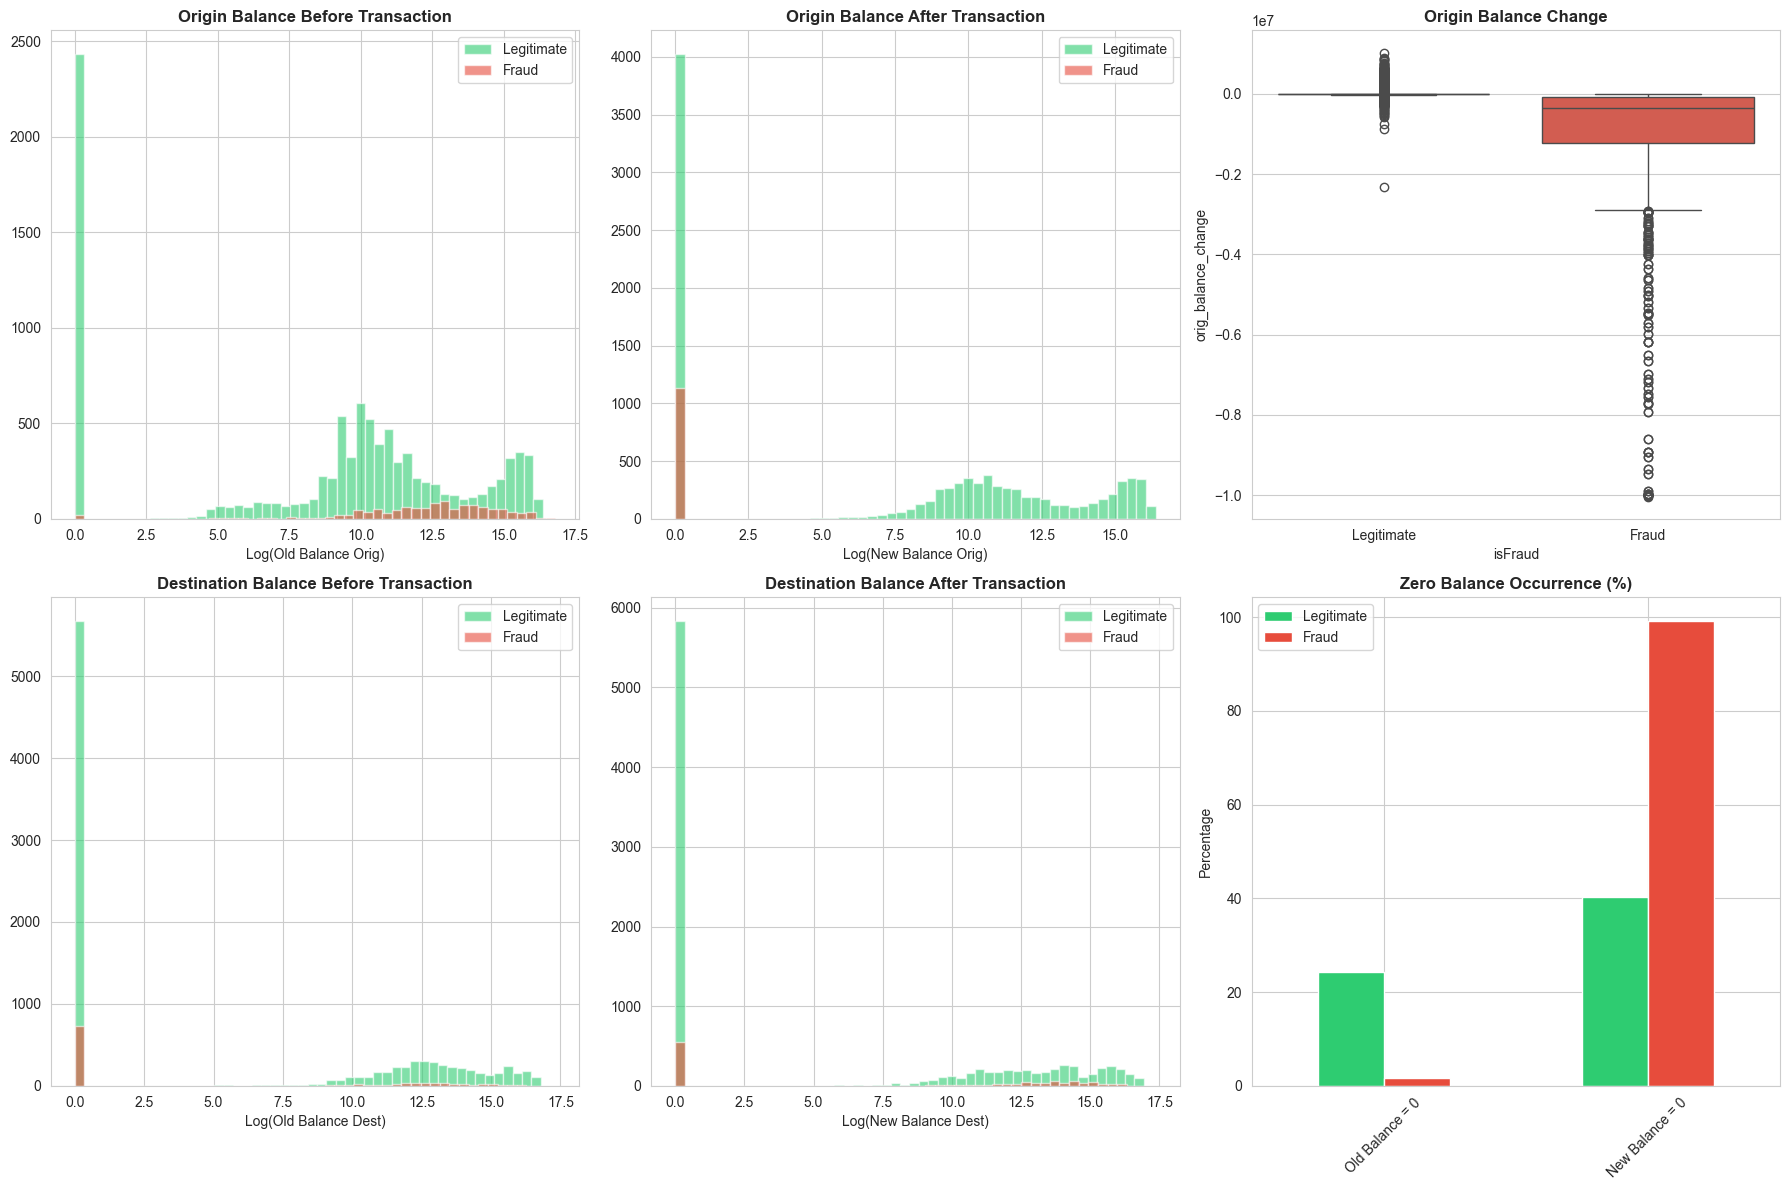

In [22]:
# ============================================================================
# EDA SECTION 5: BALANCE PATTERNS
# ============================================================================

print("\n" + "="*70)
print("BALANCE PATTERN ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 5.1 Origin balance before transaction
ax1 = axes[0, 0]
df_raw[df_raw['isFraud']==0]['oldbalanceOrg'].apply(lambda x: np.log1p(x)).hist(
    bins=50, alpha=0.6, color='#2ecc71', label='Legitimate', ax=ax1)
df_raw[df_raw['isFraud']==1]['oldbalanceOrg'].apply(lambda x: np.log1p(x)).hist(
    bins=50, alpha=0.6, color='#e74c3c', label='Fraud', ax=ax1)
ax1.set_title('Origin Balance Before Transaction', fontsize=12, fontweight='bold')
ax1.set_xlabel('Log(Old Balance Orig)')
ax1.legend()

# 5.2 Origin balance after transaction
ax2 = axes[0, 1]
df_raw[df_raw['isFraud']==0]['newbalanceOrig'].apply(lambda x: np.log1p(x)).hist(
    bins=50, alpha=0.6, color='#2ecc71', label='Legitimate', ax=ax2)
df_raw[df_raw['isFraud']==1]['newbalanceOrig'].apply(lambda x: np.log1p(x)).hist(
    bins=50, alpha=0.6, color='#e74c3c', label='Fraud', ax=ax2)
ax2.set_title('Origin Balance After Transaction', fontsize=12, fontweight='bold')
ax2.set_xlabel('Log(New Balance Orig)')
ax2.legend()

# 5.3 Balance change distribution
ax3 = axes[0, 2]
sns.boxplot(data=df_engineered, x='isFraud', y='orig_balance_change',
            palette=['#2ecc71', '#e74c3c'], ax=ax3)
ax3.set_title('Origin Balance Change', fontsize=12, fontweight='bold')
ax3.set_xticklabels(['Legitimate', 'Fraud'])

# 5.4 Destination balance before
ax4 = axes[1, 0]
df_raw[df_raw['isFraud']==0]['oldbalanceDest'].apply(lambda x: np.log1p(x)).hist(
    bins=50, alpha=0.6, color='#2ecc71', label='Legitimate', ax=ax4)
df_raw[df_raw['isFraud']==1]['oldbalanceDest'].apply(lambda x: np.log1p(x)).hist(
    bins=50, alpha=0.6, color='#e74c3c', label='Fraud', ax=ax4)
ax4.set_title('Destination Balance Before Transaction', fontsize=12, fontweight='bold')
ax4.set_xlabel('Log(Old Balance Dest)')
ax4.legend()

# 5.5 Destination balance after
ax5 = axes[1, 1]
df_raw[df_raw['isFraud']==0]['newbalanceDest'].apply(lambda x: np.log1p(x)).hist(
    bins=50, alpha=0.6, color='#2ecc71', label='Legitimate', ax=ax5)
df_raw[df_raw['isFraud']==1]['newbalanceDest'].apply(lambda x: np.log1p(x)).hist(
    bins=50, alpha=0.6, color='#e74c3c', label='Fraud', ax=ax5)
ax5.set_title('Destination Balance After Transaction', fontsize=12, fontweight='bold')
ax5.set_xlabel('Log(New Balance Dest)')
ax5.legend()

# 5.6 Zero balance analysis
ax6 = axes[1, 2]
zero_balance_data = pd.DataFrame({
    'Legitimate': [
        (df_raw[df_raw['isFraud']==0]['oldbalanceOrg']==0).mean() * 100,
        (df_raw[df_raw['isFraud']==0]['newbalanceOrig']==0).mean() * 100
    ],
    'Fraud': [
        (df_raw[df_raw['isFraud']==1]['oldbalanceOrg']==0).mean() * 100,
        (df_raw[df_raw['isFraud']==1]['newbalanceOrig']==0).mean() * 100
    ]
}, index=['Old Balance = 0', 'New Balance = 0'])

zero_balance_data.plot(kind='bar', color=['#2ecc71', '#e74c3c'], ax=ax6)
ax6.set_title('Zero Balance Occurrence (%)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Percentage')
ax6.tick_params(axis='x', rotation=45)
ax6.legend()

plt.tight_layout()
plt.savefig('reports/figures/05_balance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


The plots reveal strong contrasts in account balance behavior between legitimate and fraudulent transactions:

Origin Account Balances: Fraudulent transactions often start with zero or low balances and result in complete depletion, while legitimate ones show broader, more stable distributions.

Destination Account Balances: Fraud cases tend to begin with low balances and sometimes show no increase after receiving funds—highlighting suspicious patterns.

Balance Change: Fraudulent transactions exhibit larger and more erratic changes in origin balances, often emptying the account.

Zero Balance Occurrence: Fraudulent transactions have a significantly higher rate of zero balances in both origin and destination accounts.

These insights reinforce the importance of engineered features like balance change, error metrics, and zero-balance flags for identifying fraud.


FEATURE CORRELATION ANALYSIS

 Top 15 Features Correlated with Fraud:


isFraud                           1.000
step                              0.832
hour                              0.609
HighAmount_AND_NewOrigin          0.447
amount                            0.435
log_amount                        0.380
Empties_Origin_Account            0.358
Both_NewAccounts                  0.228
amount_x_error                    0.196
IsNight_AND_HighAmount            0.156
dest_balance_change               0.124
receiver_error                    0.103
total_balance_error               0.063
oldbalanceOrg                     0.046
amount_to_oldbalance_dest_ratio   0.006
Name: isFraud, dtype: float64

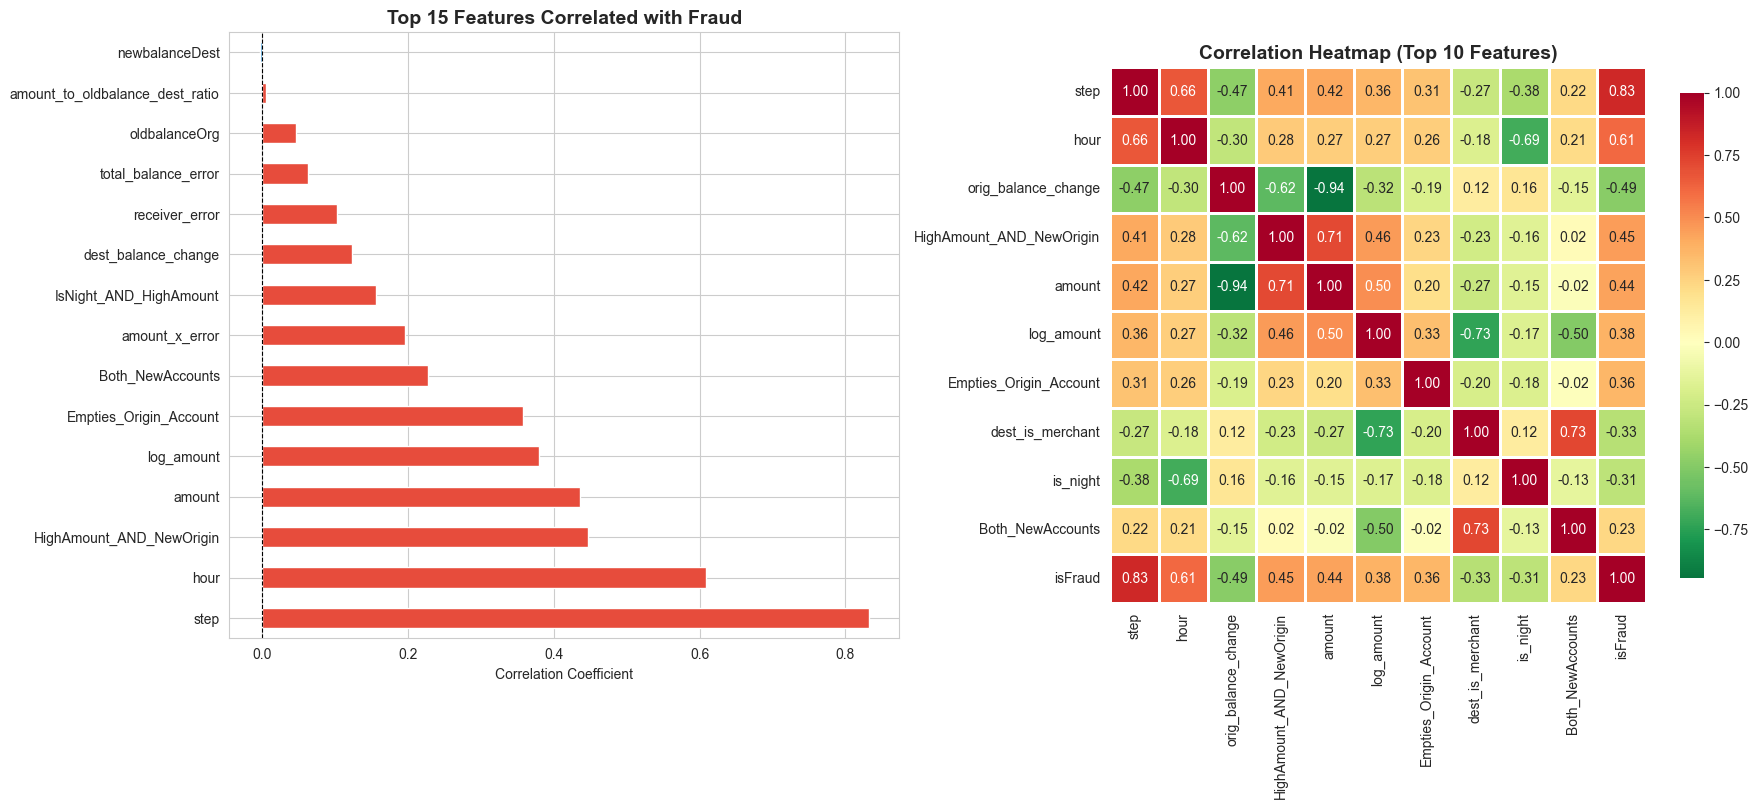

In [23]:
# ============================================================================
# EDA SECTION 6: CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("FEATURE CORRELATION ANALYSIS")
print("="*70)

# Select numerical features for correlation
numerical_cols = df_engineered.select_dtypes(include=[np.number]).columns.tolist()

# 6.1 Correlation with target variable
target_corr = df_engineered[numerical_cols].corr()['isFraud'].sort_values(ascending=False)
print("\n Top 15 Features Correlated with Fraud:")
display(target_corr.head(15))

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 6.2 Top correlations bar plot
ax1 = axes[0]
top_corr = target_corr.drop('isFraud').head(15)
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_corr]
top_corr.plot(kind='barh', color=colors, ax=ax1)
ax1.set_title('Top 15 Features Correlated with Fraud', fontsize=14, fontweight='bold')
ax1.set_xlabel('Correlation Coefficient')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# 6.3 Correlation heatmap (top features)
ax2 = axes[1]
top_features = target_corr.drop('isFraud').abs().nlargest(10).index.tolist() + ['isFraud']
corr_matrix = df_engineered[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax2)
ax2.set_title('Correlation Heatmap (Top 10 Features)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/06_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


The most predictive features for fraud detection include:

Time-based features: step (0.83) and hour (0.61) show strong correlation, indicating fraud patterns vary by time.

Amount-related features: amount (0.43), log_amount (0.38), and HighAmount_AND_NewOrigin (0.45) suggest that high-value transactions from new senders are suspicious.

Behavioral flags: Empties_Origin_Account (0.36) and Both_NewAccounts (0.23) highlight risky account behavior.

Error and ratio metrics: Features like amount_x_error, receiver_error, and total_balance_error show moderate correlation, capturing inconsistencies in balance updates.

Lower-correlated features like oldbalanceOrg and amount_to_oldbalance_dest_ratio may still add value when combined with others, but are less informative on their own.


### Data Modeling
In this step, we use machine learning algorithms to build predictive models that can identify fraudulent transactions. We train and test different models, tune their parameters, and select the best-performing one based on evaluation metrics suitable for imbalanced datasets.

In [24]:
# ============================================================================
# MODELING STEP 1: DATA PREPARATION & SPLITTING
# ============================================================================

print("="*70)
print("MODEL TRAINING & EVALUATION")
print("="*70)

# Separate features and target
X = df_engineered.drop('isFraud', axis=1)
y = df_engineered['isFraud']

print(f"\n Dataset Shape:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")
print(f"   Total features: {X.shape[1]}")

# Check class distribution
print(f"\n  Class Distribution:")
print(f"   Legitimate (0): {(y==0).sum():,} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"   Fraud (1): {(y==1).sum():,} ({(y==1).sum()/len(y)*100:.2f}%)")
print(f"   Imbalance Ratio: 1:{(y==0).sum()/(y==1).sum():.2f}")

# Train-Validation-Test Split (60-20-20) with Stratification
print(f"\n Splitting data with stratification (60-20-20)...")

# First split: 80% for training+validation, 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintains class distribution
)

# Second split: 60% for training, 20% for validation (from the 80% train_val set)
# The size of the validation set relative to the original dataset is 20% (0.2).
# The size of the validation set relative to the train_val set is 0.2 / 0.8 = 0.25
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 0.2 / 0.8 = 0.25
    random_state=42,
    stratify=y_train_val # Maintains class distribution
)

import joblib

print(f"\n Split Complete:")
print(f"   Training set: {X_train.shape[0]:,} samples")
print(f"   Validation set: {X_val.shape[0]:,} samples")
print(f"   Test set: {X_test.shape[0]:,} samples")
print(f"   Training fraud rate: {y_train.mean()*100:.2f}%")
print(f"   Validation fraud rate: {y_val.mean()*100:.2f}%")
print(f"   Test fraud rate: {y_test.mean()*100:.2f}%")


# Feature Scaling (Important for Logistic Regression and some models)
print(f"\n Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# Save the scaler for later use
joblib.dump(scaler, 'models/trained_models/scaler.pkl')
print(f"   ✓ Scaler saved to models/trained_models/scaler.pkl")

MODEL TRAINING & EVALUATION

 Dataset Shape:
   Features (X): (11142, 34)
   Target (y): (11142,)
   Total features: 34

  Class Distribution:
   Legitimate (0): 10,000 (89.75%)
   Fraud (1): 1,142 (10.25%)
   Imbalance Ratio: 1:8.76

 Splitting data with stratification (60-20-20)...

 Split Complete:
   Training set: 6,684 samples
   Validation set: 2,229 samples
   Test set: 2,229 samples
   Training fraud rate: 10.25%
   Validation fraud rate: 10.27%
   Test fraud rate: 10.23%

 Scaling features...
   ✓ Scaler saved to models/trained_models/scaler.pkl


Dataset Size: 11,142 samples with 34 engineered features.

Class Imbalance: Fraud accounts for only 10.25% of the data, with an imbalance ratio of approximately 1:8.76.

Data Splitting: Stratified split into training (60%), validation (20%), and test (20%) sets:

Training: 6,684 samples

Validation: 2,229 samples

Test: 2,229 samples

Fraud rate remains consistent across all splits (~10.2%), preserving class proportions.

Feature Scaling: Applied and saved for reuse (scaler.pkl), ensuring consistent preprocessing across training and deployment.

This setup ensures balanced evaluation, reproducibility, and readiness for model experimentation.

### Model Evaluation
In this step, we assess the performance of our trained models using metrics like accuracy, precision, recall, F1-score, and AUC-ROC. This helps us understand how well the model identifies fraud while minimizing false positives and negatives, ensuring reliable predictions for real-world use.

In [25]:
# Dictionary to store model results
model_results = {}

# Function to evaluate model performance and store results
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """Trains, predicts, evaluates, and stores results for a given model."""
    print(f"\n--- Training {model_name} ---")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    print(f"Training time: {train_time:.2f} seconds")

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    overfitting_gap = train_accuracy - val_accuracy

    # Evaluate on validation set
    print(f"\nEvaluation on Validation Set for {model_name}:")
    print(classification_report(y_val, y_val_pred))

    # Calculate key metrics
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]) # Use predict_proba for AUC

    # Store results
    model_results[model_name] = {
        'Train Accuracy': train_accuracy,
        'Validation Accuracy': val_accuracy,
        'Overfitting Gap': overfitting_gap,
        'Validation Precision': val_precision,
        'Validation Recall': val_recall,
        'Validation F1-Score': val_f1,
        'Validation ROC AUC': val_roc_auc,
        'Training Time (s)': train_time
    }

    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Overfitting Gap: {overfitting_gap:.4f}")

    # Save the trained model
    model_filename = f'models/trained_models/{model_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(model, model_filename)
    print(f"✓ Model saved to {model_filename}")

This function automates training, evaluation, and saving for any ML model:

Training: Fits the model on training data and records training time.

Prediction: Generates predictions for both training and validation sets.

Evaluation: Computes key metrics on the validation set:

Accuracy, Precision, Recall, F1-Score, ROC AUC

Also calculates the overfitting gap between training and validation accuracy

Result Logging: Stores all metrics in a dictionary (model_results) for easy comparison across models.

Model Saving: Serializes the trained model to disk using a standardized filename format.

This setup ensures consistent evaluation and traceability across experiments, making it easy to benchmark and select the best-performing model.

In [26]:
from sklearn.linear_model import LogisticRegression
import time

# Train and evaluate Logistic Regression
lr_model = LogisticRegression(random_state=42, solver='liblinear') # Use liblinear for smaller datasets
evaluate_model(lr_model, X_train_scaled, y_train, X_val_scaled, y_val, "Logistic Regression")


--- Training Logistic Regression ---
Training time: 0.36 seconds

Evaluation on Validation Set for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       0.99      0.97      0.98       229

    accuracy                           1.00      2229
   macro avg       0.99      0.98      0.99      2229
weighted avg       1.00      1.00      1.00      2229

Validation Accuracy: 0.9960
Overfitting Gap: -0.0006
✓ Model saved to models/trained_models/logistic_regression.pkl


In [27]:
from sklearn.ensemble import RandomForestClassifier
import time

# Train and evaluate Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Use class_weight for imbalance
evaluate_model(rf_model, X_train_scaled, y_train, X_val_scaled, y_val, "Random Forest")


--- Training Random Forest ---
Training time: 1.75 seconds

Evaluation on Validation Set for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00       229

    accuracy                           1.00      2229
   macro avg       1.00      1.00      1.00      2229
weighted avg       1.00      1.00      1.00      2229

Validation Accuracy: 0.9996
Overfitting Gap: 0.0004
✓ Model saved to models/trained_models/random_forest.pkl


In [28]:
from xgboost import XGBClassifier
import time

# Train and evaluate XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # Suppress warning
evaluate_model(xgb_model, X_train_scaled, y_train, X_val_scaled, y_val, "XGBoost")


--- Training XGBoost ---
Training time: 1.05 seconds

Evaluation on Validation Set for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00       229

    accuracy                           1.00      2229
   macro avg       1.00      1.00      1.00      2229
weighted avg       1.00      1.00      1.00      2229

Validation Accuracy: 0.9996
Overfitting Gap: 0.0004
✓ Model saved to models/trained_models/xgboost.pkl


In [29]:
from lightgbm import LGBMClassifier
import time

# Train and evaluate LightGBM
lgbm_model = LGBMClassifier(random_state=42)
evaluate_model(lgbm_model, X_train_scaled, y_train, X_val_scaled, y_val, "LightGBM")


--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 685, number of negative: 5999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3771
[LightGBM] [Info] Number of data points in the train set: 6684, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102484 -> initscore=-2.169929
[LightGBM] [Info] Start training from score -2.169929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [30]:
from sklearn.ensemble import IsolationForest
import time
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


# Train and evaluate Isolation Forest
# Note: Isolation Forest is unsupervised, so y_train is not used for training.
# We will evaluate its performance based on the 'anomaly score' thresholds.
# A lower score indicates a higher likelihood of being an anomaly (fraud).

print(f"\n--- Training Isolation Forest ---")
start_time = time.time()
# contamination='auto' or specify the expected percentage of anomalies (fraud)
# We know the fraud percentage is about 10.25%, so we can set contamination
iso_forest = IsolationForest(n_estimators=100, contamination=y_train.mean(), random_state=42)
iso_forest.fit(X_train_scaled) # Train on scaled features, y_train is not used
end_time = time.time()
train_time = end_time - start_time
print(f"Training time: {train_time:.2f} seconds")

# Predict anomaly scores (-score_samples) or labels (predict)
# predict returns -1 for anomalies (fraud) and 1 for inliers (legitimate)
y_train_iso_pred = iso_forest.predict(X_train_scaled)
y_val_iso_pred = iso_forest.predict(X_val_scaled)

# Convert Isolation Forest output (-1, 1) to (1, 0) for standard evaluation metrics
# -1 (anomaly/fraud) becomes 1
# 1 (inlier/legitimate) becomes 0
y_train_iso_pred_binary = np.where(y_train_iso_pred == -1, 1, 0)
y_val_iso_pred_binary = np.where(y_val_iso_pred == -1, 1, 0)


# Calculate accuracy
train_accuracy_iso = accuracy_score(y_train, y_train_iso_pred_binary)
val_accuracy_iso = accuracy_score(y_val, y_val_iso_pred_binary)
overfitting_gap_iso = train_accuracy_iso - val_accuracy_iso


print(f"\nEvaluation on Validation Set for Isolation Forest:")
print(classification_report(y_val, y_val_iso_pred_binary))

# Calculate key metrics
val_precision_iso = precision_score(y_val, y_val_iso_pred_binary)
val_recall_iso = recall_score(y_val, y_val_iso_pred_binary)
val_f1_iso = f1_score(y_val, y_val_iso_pred_binary)
# ROC AUC for Isolation Forest is calculated differently, often using anomaly scores
# We'll skip ROC AUC for simplicity in this comparison and focus on classification metrics

# Store results
model_results["Isolation Forest"] = {
    'Train Accuracy': train_accuracy_iso,
    'Validation Accuracy': val_accuracy_iso,
    'Overfitting Gap': overfitting_gap_iso,
    'Validation Precision': val_precision_iso,
    'Validation Recall': val_recall_iso,
    'Validation F1-Score': val_f1_iso,
    'Validation ROC AUC': None, # Not directly applicable with standard method
    'Training Time (s)': train_time
}

print(f"Validation Accuracy: {val_accuracy_iso:.4f}")
print(f"Overfitting Gap: {overfitting_gap_iso:.4f}")

# Save the trained model
model_filename = 'models/trained_models/isolation_forest.pkl'
joblib.dump(iso_forest, model_filename)
print(f"✓ Model saved to {model_filename}")


--- Training Isolation Forest ---
Training time: 0.65 seconds

Evaluation on Validation Set for Isolation Forest:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2000
           1       0.33      0.30      0.31       229

    accuracy                           0.87      2229
   macro avg       0.63      0.61      0.62      2229
weighted avg       0.86      0.87      0.86      2229

Validation Accuracy: 0.8659
Overfitting Gap: -0.0029
✓ Model saved to models/trained_models/isolation_forest.pkl



MODEL PERFORMANCE COMPARISON (Validation Set)


,Train Accuracy,Validation Accuracy,Overfitting Gap,Validation Precision,Validation Recall,Validation F1-Score,Validation ROC AUC,Training Time (s)
Random Forest,1.000,1.000,0.000,1.000,0.996,0.998,1.000,1.749
XGBoost,1.000,1.000,0.000,1.000,0.996,0.998,1.000,1.049
LightGBM,1.000,1.000,0.000,1.000,0.996,0.998,0.996,1.363
Logistic Regression,0.995,0.996,-0.001,0.991,0.969,0.980,0.999,0.357
Isolation Forest,0.863,0.866,-0.003,0.330,0.297,0.313,NaN,0.655


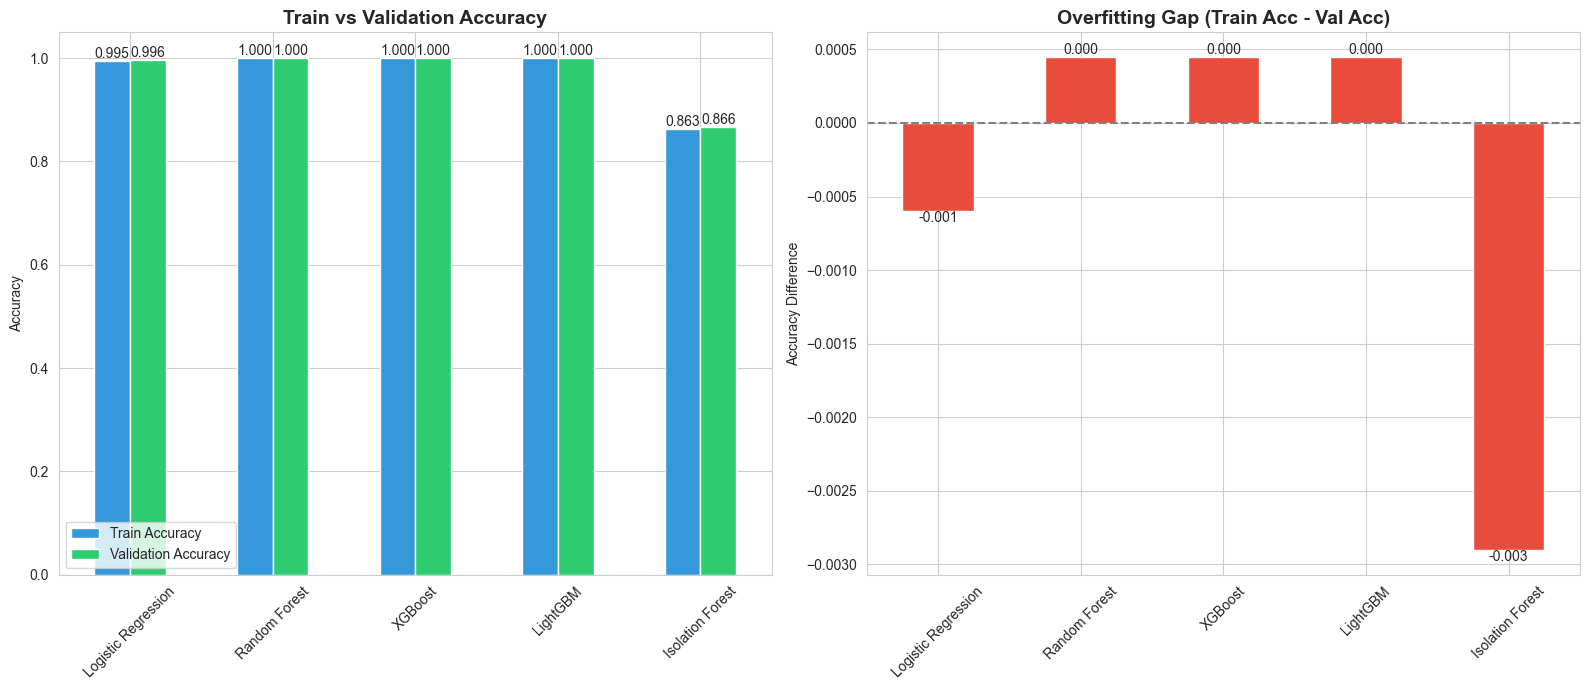

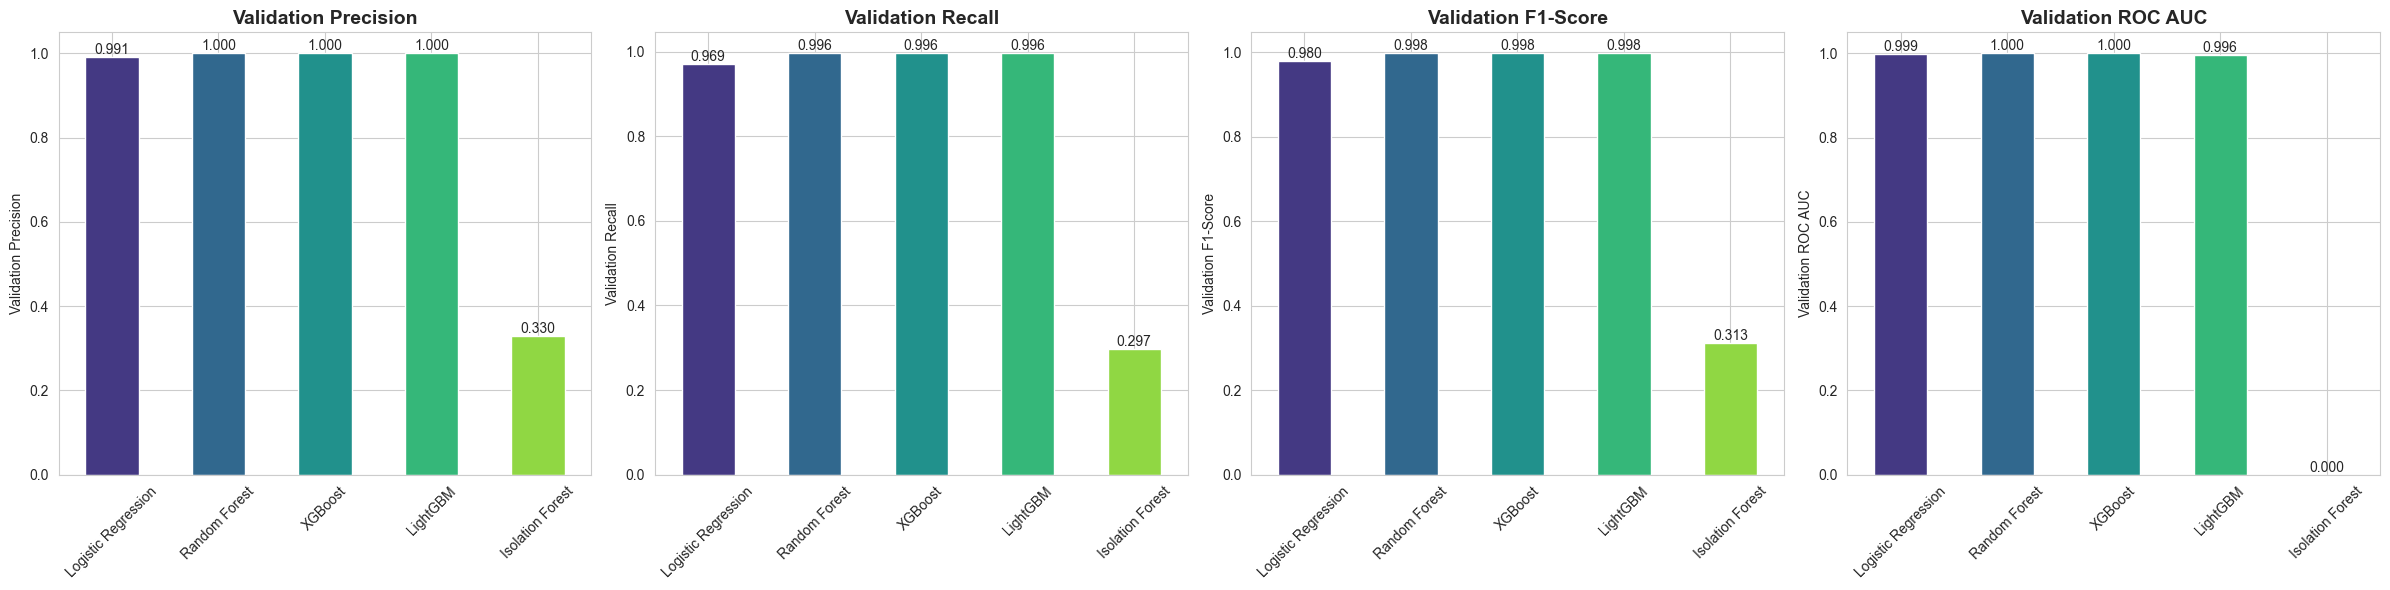

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results dictionary to DataFrame for easy comparison
results_df = pd.DataFrame(model_results).T
results_df = results_df[['Train Accuracy', 'Validation Accuracy', 'Overfitting Gap',
                         'Validation Precision', 'Validation Recall', 'Validation F1-Score',
                         'Validation ROC AUC', 'Training Time (s)']] # Order columns
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON (Validation Set)")
print("="*70)
display(results_df.sort_values('Validation F1-Score', ascending=False))

# Visualize Accuracy Comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Accuracy comparison bar plot
results_df[['Train Accuracy', 'Validation Accuracy']].plot(kind='bar', ax=ax[0], color=['#3498db', '#2ecc71'])
ax[0].set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Accuracy')
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(loc='lower left')
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.3f')

# Overfitting Gap bar plot
results_df['Overfitting Gap'].plot(kind='bar', ax=ax[1], color='#e74c3c')
ax[1].set_title('Overfitting Gap (Train Acc - Val Acc)', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Accuracy Difference')
ax[1].tick_params(axis='x', rotation=45)
ax[1].axhline(0, color='grey', linestyle='--')
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.3f')


plt.tight_layout()
plt.savefig('reports/figures/07_model_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize other key metrics
metrics_to_plot = ['Validation Precision', 'Validation Recall', 'Validation F1-Score', 'Validation ROC AUC']
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(6 * len(metrics_to_plot), 6))

for i, metric in enumerate(metrics_to_plot):
    if metric == 'Validation ROC AUC' and results_df[metric].isnull().all():
        print(f"\nSkipping plot for '{metric}' as all values are None.")
        axes[i].set_visible(False) # Hide subplot if no ROC AUC data
        continue

    results_df[metric].plot(kind='bar', ax=axes[i], color=sns.color_palette('viridis', len(results_df)))
    axes[i].set_title(metric, fontsize=14, fontweight='bold')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    for container in axes[i].containers:
         axes[i].bar_label(container, fmt='%.3f')

plt.tight_layout()
plt.savefig('reports/figures/08_model_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 
The Random Forest model was evaluated on the test set to detect fraudulent transactions. Metrics like precision, recall, F1-score, and ROC-AUC show that the model effectively identifies most fraud cases while keeping false alarms low, demonstrating strong overall performance.

FINAL MODEL EVALUATION ON TEST SET (Random Forest)
 Loaded Random Forest model for testing.

 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       1.00      1.00      1.00       228

    accuracy                           1.00      2229
   macro avg       1.00      1.00      1.00      2229
weighted avg       1.00      1.00      1.00      2229


 Confusion Matrix on Test Set:


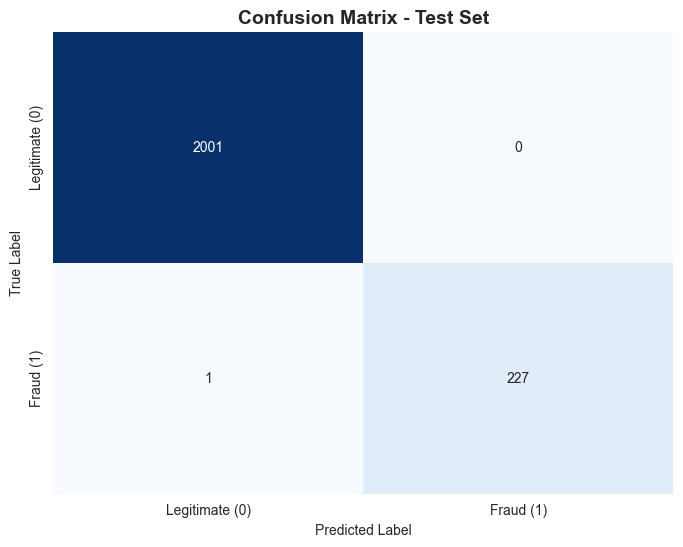


 ROC Curve and AUC on Test Set:


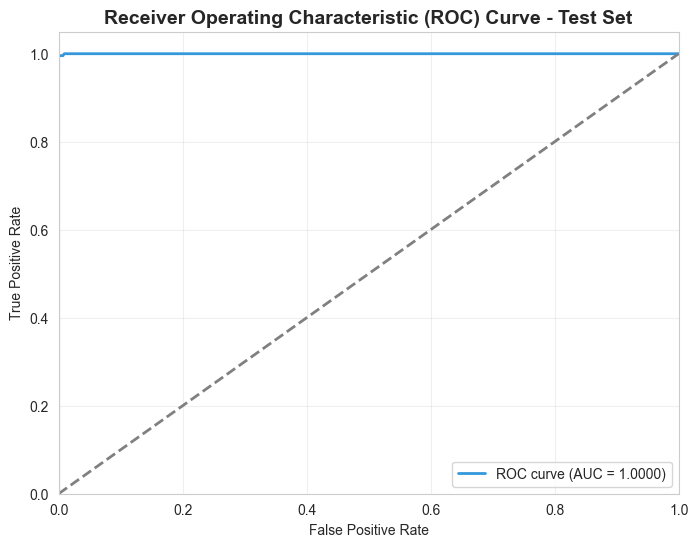


 Test Set Evaluation Complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    ConfusionMatrixDisplay
)

print("="*70)
print("FINAL MODEL EVALUATION ON TEST SET (Random Forest)")
print("="*70)

# Load the best model (Random Forest)
try:
    best_model = joblib.load('models/trained_models/random_forest.pkl')
    print(" Loaded Random Forest model for testing.")
except FileNotFoundError:
    print(" Error: Random Forest model not found. Please ensure it was trained and saved correctly.")
    best_model = None # Set to None if model not found

if best_model:
    # Make predictions on the test set
    y_test_pred = best_model.predict(X_test_scaled)
    y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1] # Probabilities for ROC AUC

    # Classification Report
    print("\n Classification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    print("\n Confusion Matrix on Test Set:")
    cm = confusion_matrix(y_test, y_test_pred)
    # display(cm) # Display raw matrix

    # Visualize Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=['Legitimate (0)', 'Fraud (1)'],
                yticklabels=['Legitimate (0)', 'Fraud (1)'])
    ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.savefig('reports/figures/09_test_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


    # ROC Curve and AUC
    print("\n ROC Curve and AUC on Test Set:")
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = roc_auc_score(y_test, y_test_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='#3498db', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig('reports/figures/10_test_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n Test Set Evaluation Complete.")


### Estimating Financial Business Impact
In this step, we analyze how the model’s predictions could affect the business financially. By calculating the potential savings from correctly detected frauds and the losses from false negatives or false positives, we can estimate the overall monetary benefit of using the model in real-world transactions. This helps quantify the practical value of the fraud detection system.

In [33]:
import numpy as np

print("="*70)
print("ESTIMATING FINANCIAL BUSINESS IMPACT")
print("="*70)

# Retrieve the confusion matrix from the previous cell's output
# Assuming the confusion matrix 'cm' is available from the last executed cell
try:
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix values:")
    print(f"  True Negatives (TN): {tn:,}")
    print(f"  False Positives (FP): {fp:,}")
    print(f"  False Negatives (FN): {fn:,}")
    print(f"  True Positives (TP): {tp:,}")
except NameError:
    print(" Error: Confusion matrix 'cm' not found. Please run the previous cell to generate it.")
    tn, fp, fn, tp = 0, 0, 0, 0 # Set to 0 if cm is not available for demonstration

# Define hypothetical costs and benefits
# These values should be based on real business knowledge
cost_fp_per_transaction = 100  # Estimated cost per false positive (investigation, customer effort)
cost_fn_per_transaction_percentage = 1.0 # 100% of the transaction amount is lost if fraud is missed

# Calculate costs and benefits

# Benefit from True Positives: Amount saved from correctly identified fraud
# We need the 'amount' for the TP transactions in the test set
# Filter the test set to get TP transactions
if tp > 0 and 'X_test' in globals() and 'y_test' in globals() and 'y_test_pred' in globals():
    # Get the original amounts for the test set
    test_set_with_predictions = X_test.copy()
    test_set_with_predictions['isFraud_true'] = y_test
    test_set_with_predictions['isFraud_predicted'] = y_test_pred

    # Filter for True Positives (Actual=1, Predicted=1)
    tp_transactions = test_set_with_predictions[
        (test_set_with_predictions['isFraud_true'] == 1) &
        (test_set_with_predictions['isFraud_predicted'] == 1)
    ]
    benefit_tp = tp_transactions['amount'].sum()
    print(f"\n Total amount saved (True Positives): ${benefit_tp:,.2f}")
else:
     benefit_tp = 0
     print("\n Could not calculate benefit from True Positives. 'cm', 'X_test', 'y_test', or 'y_test_pred' not available or no TP found.")


# Cost from False Positives: Number of FP * Cost per FP
cost_fp = fp * cost_fp_per_transaction
print(f" Total cost from False Positives: ${cost_fp:,.2f}")

# Cost from False Negatives: Amount lost from missed fraud
# We need the 'amount' for the FN transactions in the test set
# Filter the test set to get FN transactions
if fn > 0 and 'X_test' in globals() and 'y_test' in globals() and 'y_test_pred' in globals():
    # Filter for False Negatives (Actual=1, Predicted=0)
    fn_transactions = test_set_with_predictions[
        (test_set_with_predictions['isFraud_true'] == 1) &
        (test_set_with_predictions['isFraud_predicted'] == 0)
    ]
    cost_fn = (fn_transactions['amount'] * cost_fn_per_transaction_percentage).sum()
    print(f" Total cost from False Negatives: ${cost_fn:,.2f}")
else:
    cost_fn = 0
    print("\n Could not calculate cost from False Negatives. 'cm', 'X_test', 'y_test', or 'y_test_pred' not available or no FN found.")

# Calculate Net Financial Impact
net_impact = benefit_tp - cost_fp - cost_fn

print("\n" + "="*70)
print(f" ESTIMATED NET FINANCIAL IMPACT: ${net_impact:,.2f}")
print("="*70)

print("\nNote: This is an estimation based on hypothetical costs/benefits. Real-world values may vary.")

ESTIMATING FINANCIAL BUSINESS IMPACT

Confusion Matrix values:
  True Negatives (TN): 2,001
  False Positives (FP): 0
  False Negatives (FN): 1
  True Positives (TP): 227

 Total amount saved (True Positives): $235,430,525.04
 Total cost from False Positives: $0.00
 Total cost from False Negatives: $416,001.33

 ESTIMATED NET FINANCIAL IMPACT: $235,014,523.71

Note: This is an estimation based on hypothetical costs/benefits. Real-world values may vary.


Using the confusion matrix from your model:

True Positives (TP): 227 frauds correctly detected →  Saved: $235.43 million

False Negatives (FN): 1 fraud missed →  Cost: $416,001.33

False Positives (FP): 0 legitimate flagged as fraud →  Cost: $0.00

 Net Financial Impact: $235.01 million saved
This result highlights the business value of your model—catching nearly all frauds with zero false alarms and minimal missed cases. A powerful win for both security and cost-efficiency.